In [1]:
%run imports.py

Succesfully imported libraries and modules



We want to correlate spectral power and PAC intensity for a given frequency range.

Spectral power can be calculated 2 ways:
1) Sliding window over frequency and averaging spectral power (I suggest window size equal to 1.5 * bandwidth of PAC estimation filter for phase-giving oscillation)
2) FOOOF 1/f removal and estimation of power of whitened spectrum and/or sliding window spectral power mean

PAC intensity could be calculated as following:
* We don't consider y-axis frequencies below 150 Hz (N:M coupling occurs mostly below that point)
* Average or max-value (or any matrix norm essentially) of **significant** PAC in every column corresponding to the phase-giving frequency



In [2]:
def copy_patient(patient: Patient):
    new_patient = Patient(patient.name, patient.root_dir)
    for attr in patient.__dict__.keys():
        new_patient.__dict__[attr] = patient.__dict__[attr]
    return new_patient

In [3]:
def load_patients(who='all', n_total=6):
    """
    who: either all or list of patient numbers
    Returns: list of patient instances
    """
    
    with open("path_data.txt") as f:
        data_dir = f.readline()
        print(f"Reading patients in directory {data_dir}")
        
    p_list = []
        
    if who == 'all':
        iterable = range(1, n_total + 1)    
    else:
        iterable = who
        
    for i in iterable:
        print(f"Reading Patient{i}")
        p_dir = os.path.join(data_dir, f"Patient{i}")
        p_pickle_filepath = os.path.join(p_dir, f"Patient{i}.pkl")
        p = load_patient_from_pickle(p_pickle_filepath)
        p = copy_patient(p)
        p.root_dir = p_dir
        p.load_all_pacs(verbose=False)
        p_list.append(p)
        
    print("Done, returning list of patients")
    return p_list

## Patient 1: Beta - PAC correlation

In [3]:
patient = load_patient(1)

Patient directory:  D:\LAB\AlexPAC\data\Patient1


In [4]:
# example PAC and lfp spectrum

condition = "5Day OFF Rest 180sec"
placement = "R2B-3B"

pac = patient.pac[condition][placement][placement]
lfp = patient.lfp[condition][placement]

print(pac.beta_params)

(5, 48, 1, 2)


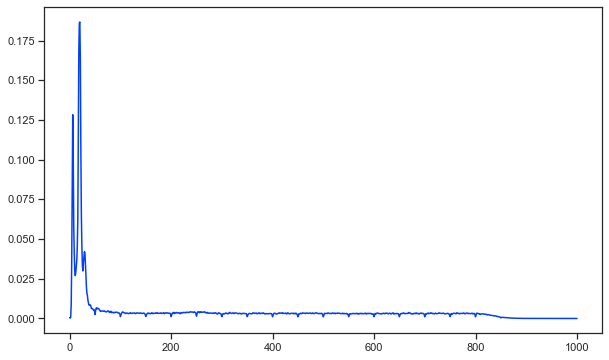

In [5]:
plt.plot(*lfp.get_psd())

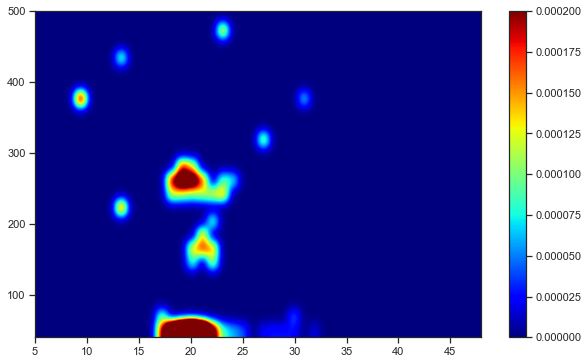

In [6]:
comodulogram(pac.pac_matrix, pac.beta_params, pac.hfo_params, pac.pvalues, significant=True, vmax=0.0002)
plt.colorbar()

#### LFP spectral power

In [19]:
f1, f2 = 4, 36 # beta freqs of interest (we really want from 5 to 35 but that's another story )

f, psd = lfp.get_psd()
mask = (f >= f1) & (f <= f2)

kernel = np.ones(3)/3
psd_average_power = np.convolve(psd[mask], kernel, mode='valid')
# Получили скользящее среднее, при этом первая точка отвечает за 5, а последняя - за 35 - отлично! 31 точка всего

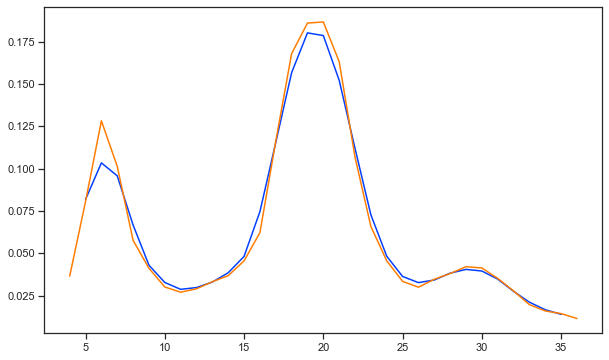

In [24]:
plt.plot(np.arange(5, 36), psd_average_power)
plt.plot(f[mask], psd[mask])

#### PAC power

In [9]:
zero_indices = (pac.pvalues > 0.01)
pac_matrix = pac.pac_matrix.copy()
pac_matrix[zero_indices] = 0

# average pac power above 160Hz is [6:, :].mean(axis=0)
# for beta it is 5 to 35

pac_power_mean = pac_matrix[6:, :31].mean(axis=0)
pac_power_max = pac_matrix[6:, :31].max(axis=0)
pac_power_mean.shape

(31,)

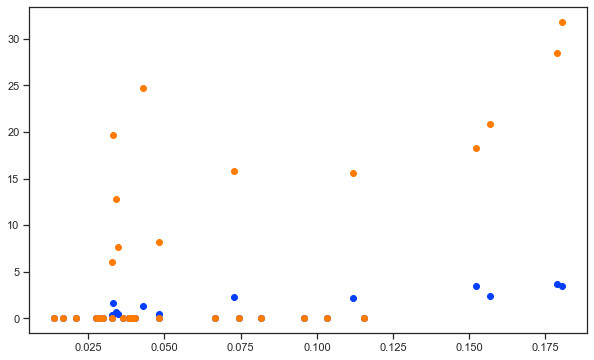

In [10]:
plt.scatter(psd_average_power, pac_power_mean * 1e+5)
plt.scatter(psd_average_power, pac_power_max * 1e+5)

In [11]:
np.corrcoef(psd_average_power, pac_power_max)

array([[1.        , 0.62428048],
       [0.62428048, 1.        ]])

In [12]:
spectral_power = np.array([])
pac_max_power = np.array([])
pac_mean_power = np.array([])

for condition in patient.conditions:
    if '180sec' in condition:
        for placement in patient.placements:
            lfp = patient.lfp[condition][placement]
            pac = patient.pac[condition][placement][placement]
            
            # spectral power
            f1, f2 = 4, 36
            f, psd = lfp.get_psd()
            mask = (f >= f1) & (f <= f2)

            kernel = np.ones(3)/3
            psd_average_power = np.convolve(psd[mask], kernel, mode='valid')
            
            # pac power
            zero_indices = (pac.pvalues > 0.01)
            pac_matrix = pac.pac_matrix.copy()
            pac_matrix[zero_indices] = 0

            pac_mean = pac_matrix[6:, :31].mean(axis=0)
            pac_max = pac_matrix[6:, :31].max(axis=0)
            
            spectral_power = np.concatenate((spectral_power, psd_average_power))
            pac_max_power = np.concatenate((pac_max_power, pac_max))
            pac_mean_power = np.concatenate((pac_mean_power, pac_mean))

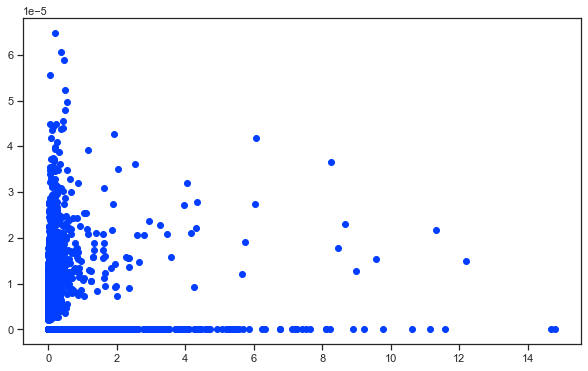

In [13]:
plt.scatter(spectral_power, pac_mean_power)

In [14]:
print(np.corrcoef(spectral_power, pac_mean_power))

print(np.corrcoef(spectral_power, pac_max_power))

[[1.         0.09880446]
 [0.09880446 1.        ]]
[[1.         0.12266818]
 [0.12266818 1.        ]]


Fixing Patient3 with copying its attributes

In [15]:
with open("path_data.txt") as f:
    data_dir = f.readline()
p3_dir = os.path.join(data_dir, "Patient3")
print("Patient directory: ", p3_dir)
p3_pickle_filepath = os.path.join(p3_dir, "Patient3.pkl")
p3 = load_patient_from_pickle(p3_pickle_filepath)
p3.root_dir = p3_dir

p3 = copy_patient(p3)

p3.load_all_pacs(verbose=False)
p3.save()

Patient directory:  D:\LAB\AlexPAC\data\Patient3
List of things to make sure before analysis: 
1) .bdf files are in patient folder (root_dir)
2) annotation files share the same name as .bdf files but with _annotations.txt suffix
3) annotations share the same naming principle: e.g. 1Day OFF RH (Com)
Saving Patient3 object to D:\LAB\AlexPAC\data\Patient3\Patient3.pkl ...
Pickling Patient3 without ['pac']
Done, 3.1399266719818115 sec
File size: 3449.7953786849976 MB
Returning filepath for saved file


'D:\\LAB\\AlexPAC\\data\\Patient3\\Patient3.pkl'

#### Trying FOOOF method

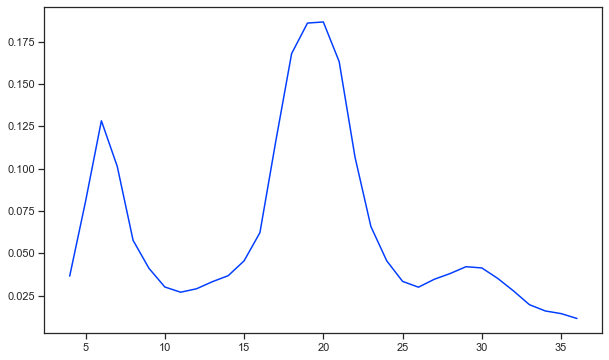


FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 1.00 <= 1.00
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.



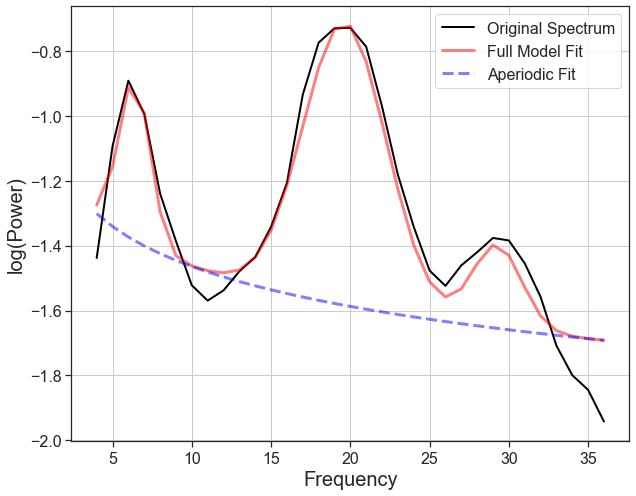

In [32]:
from fooof import FOOOF

f1, f2 = 4, 36 # beta freqs of interest (we really want from 5 to 35 but that's another story )

f, psd = lfp.get_psd()
mask = (f >= f1) & (f <= f2)

plt.plot(f[mask], psd[mask])
plt.show()

fm = FOOOF(peak_width_limits=(1, 12), max_n_peaks=3, peak_threshold=1)

fm.fit(f[mask], psd[mask])

fm.plot()
# Получили скользящее среднее, при этом первая точка отвечает за 5, а последняя - за 35 - отлично! 31 точка всего

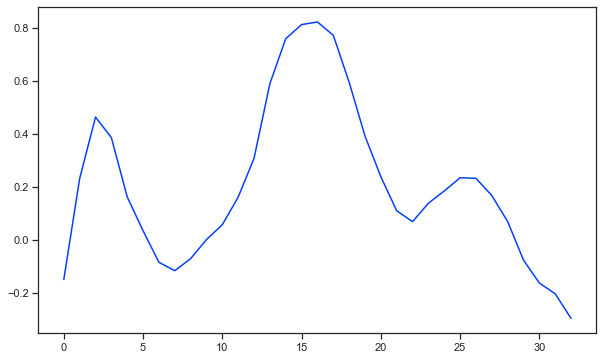

In [42]:
init_flat_spec = fm.power_spectrum - init_ap_fit


plt.plot(init_flat_spec)

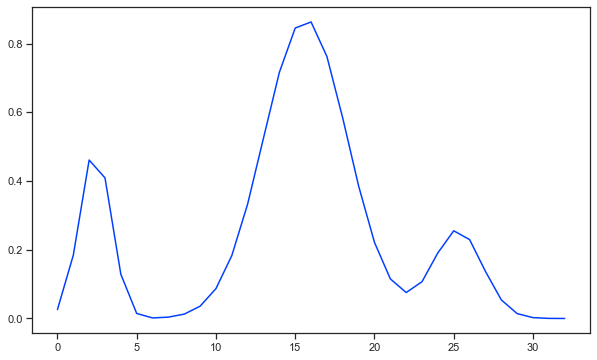

In [44]:
plt.plot(fm._peak_fit)

In [45]:
fm._peak_fit.shape

(33,)

In [47]:
f[mask].shape

(33,)

## Main correlation function

In [8]:
def get_spectral_pac_correlation(patient, 
                                 freqs=(5, 36), 
                                 spectral_power='fooof', 
                                 pac_power='max', 
                                 convolve=False, 
                                 ignore_pac_zeros=False):
    """
    Return arrays of spectral and pac powers (parametrized by similar freq range)
    Spectral power: 'psd' or 'fooof'
    PAC power: 'max', 'mean' or 'mean_squared'
    """
    spectral_power_values = np.array([])
    pac_power_values = np.array([])
    
    F0, F1 = 4, 48

    for condition in patient.conditions:
        if '180sec' in condition:
            for placement in patient.placements:
                lfp = patient.lfp[condition][placement]
                pac = patient.pac[condition][placement][placement]
                
                if not pac_exists(patient, condition, placement, placement):
                    continue
                
                """ SPECTRAL POWER """
                f, psd = lfp.get_psd() 
                lf_mask = (f >= F0 - 1) & (f <= F1 + 1)   
                psd_to_convolve = psd[lf_mask]

                # using fooof to flatten the spectrum (adjusting for 1/f)
                if spectral_power == 'fooof':
                    fm = FOOOF(peak_width_limits=(1, 12), max_n_peaks=4, peak_threshold=1, verbose=False)
                    fm.fit(f[lf_mask], psd[lf_mask])
                    psd_to_convolve = fm._peak_fit
                    
                # sliding average to adjust for PAC filter bandwidth
                if convolve:
                    kernel = np.ones(3)/3
                    psd_conv = np.convolve(psd_to_convolve, kernel, mode='valid') 
                else:
                    psd_conv = psd_to_convolve[1:-1] # cut first and last for same result as convolution
                
                conv_mask = (f >= F0) & (f <= F1)
                f_conv = f[conv_mask]
                
                f0, f1 = freqs
                final_mask = (f_conv >= f0) & (f_conv <= f1)
                
                current_spectral_power = psd_conv[final_mask] # should be the length of range(f0, f1 + 1)
                
                """ PAC POWER """
                # converting pac_matrix to a significant one
                zero_indices = (pac.pvalues > 0.01)
                pac_matrix = pac.pac_matrix.copy()
                pac_matrix[zero_indices] = 0
                
                idx1 = np.argmin(np.abs(pac.beta_freqs - freqs[0]))
                idx2 = np.argmin(np.abs(pac.beta_freqs - freqs[1])) + 1
                
                if pac_power == 'max':
                    current_pac_power = pac_matrix[6:, idx1:idx2].max(axis=0)
                    
                if pac_power == 'mean':
                    current_pac_power = pac_matrix[6:, idx1:idx2].mean(axis=0)
                    
                if pac_power == 'mean_squared':
                    current_pac_power = np.sqrt(np.sum(pac_matrix[6:, idx1:idx2] ** 2, axis=0))
                    
                assert current_pac_power.shape == current_spectral_power.shape, "PAC power and spectral power shapes do not coincide"
                    
                spectral_power_values = np.concatenate((spectral_power_values, current_spectral_power))
                pac_power_values = np.concatenate((pac_power_values, current_pac_power))
                
    if ignore_pac_zeros:
        mask = pac_power_values > 0
    else:
        mask = np.ones(len(pac_power_values), dtype='bool')
                
    return spectral_power_values[mask], pac_power_values[mask]


def plot_correlation_results(spectral_power, pac_power, **plt_params):
    plt.figure(figsize=(6, 6))
    plt.title("Correlation between spectral power and PAC power \n parametrized by phase-giving frequency ")
    plt.scatter(spectral_power, pac_power, alpha=0.8)
    plt.xlabel("Spectral Power")
    plt.ylabel("PAC power")
    plt.show()
    print(f"Pearson correlation coefficient: ", np.corrcoef(spectral_power, pac_power)[0, 1].round(2))

In [7]:
(np.arange(5) > 1).dtype

dtype('bool')

Patient directory:  D:\LAB\AlexPAC\data\Patient1
Patient 1


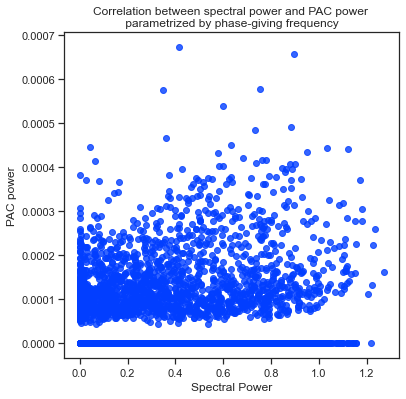

Pearson correlation coefficient:  0.19
Wall time: 38.8 s


In [11]:
%%time

p1 = load_patient(1)

print("Patient 1")
spectral_power, pac_power = get_spectral_pac_correlation(p1, freqs=(6, 30))
plot_correlation_results(spectral_power, pac_power)

Trying ignoring those points where PAC power is zero

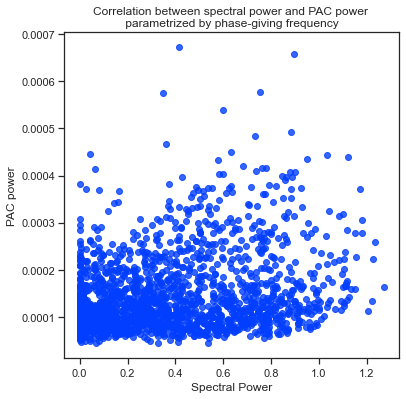

Pearson correlation coefficient:  0.3
Wall time: 33.5 s


In [12]:
%%time

spectral_power, pac_power = get_spectral_pac_correlation(p1, freqs=(6, 30), ignore_pac_zeros=True)
plot_correlation_results(spectral_power, pac_power)

In [10]:
p2 = load_patient(2)

Patient directory:  D:\LAB\AlexPAC\data\Patient2


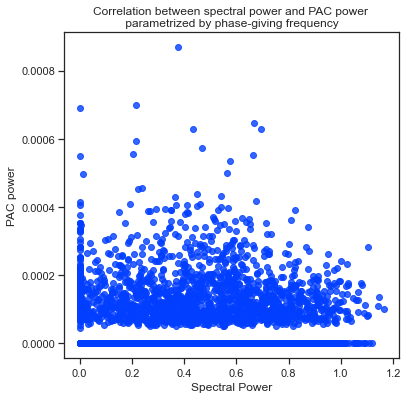

Pearson correlation coefficient:  0.15
Wall time: 16.9 s


In [74]:
%%time

print("Patient 2")
spectral_power, pac_power = get_spectral_pac_correlation(p2, freqs=(6, 30))
plot_correlation_results(spectral_power, pac_power)

In [77]:
with open("path_data.txt") as f:
    data_dir = f.readline()

p3_dir = os.path.join(data_dir, "Patient3")
print("Patient directory: ", p3_dir)
p3_pickle_filepath = os.path.join(p3_dir, "Patient3.pkl")

p3 = load_patient_from_pickle(p3_pickle_filepath)

p3.root_dir = p3_dir

p3 = copy_patient(p3)
p3.load_all_pacs(verbose=False)

Patient directory:  D:\LAB\AlexPAC\data\Patient3
List of things to make sure before analysis: 
1) .bdf files are in patient folder (root_dir)
2) annotation files share the same name as .bdf files but with _annotations.txt suffix
3) annotations share the same naming principle: e.g. 1Day OFF RH (Com)


Patient 3


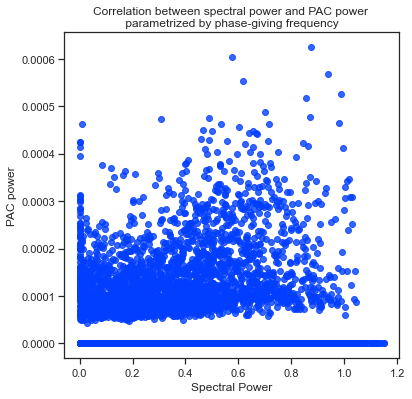

Pearson correlation coefficient:  0.15
Wall time: 22.6 s


In [81]:
%%time

print("Patient 3")
spectral_power, pac_power = get_spectral_pac_correlation(p3, freqs=(6, 30))
plot_correlation_results(spectral_power, pac_power)

In [83]:
with open("path_data.txt") as f:
    data_dir = f.readline()

p4_dir = os.path.join(data_dir, "Patient4")
print("Patient directory: ", p4_dir)
p4_pickle_filepath = os.path.join(p4_dir, "Patient4.pkl")

p4 = load_patient_from_pickle(p4_pickle_filepath)

p4.root_dir = p4_dir

p4 = copy_patient(p4)
p4.load_all_pacs(verbose=False)

Patient directory:  D:\LAB\AlexPAC\data\Patient4
List of things to make sure before analysis: 
1) .bdf files are in patient folder (root_dir)
2) annotation files share the same name as .bdf files but with _annotations.txt suffix
3) annotations share the same naming principle: e.g. 1Day OFF RH (Com)


Patient 4


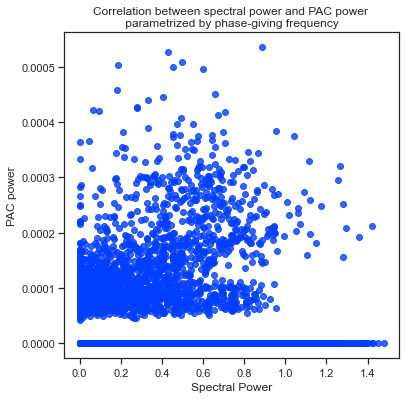

Pearson correlation coefficient:  0.11
Wall time: 25.1 s


In [84]:
%%time

print("Patient 4")
spectral_power, pac_power = get_spectral_pac_correlation(p4, freqs=(6, 30))
plot_correlation_results(spectral_power, pac_power)

Patient directory:  D:\LAB\AlexPAC\data\Patient5
Patient 5


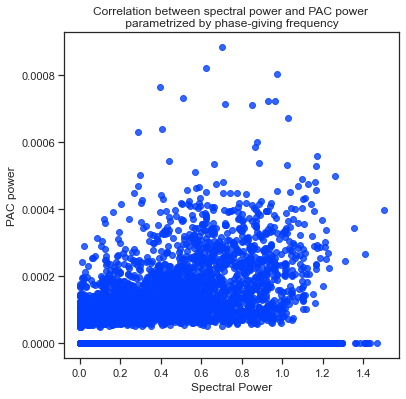

Pearson correlation coefficient:  0.23
Wall time: 25.3 s


In [85]:
%%time

p5 = load_patient(5)
print("Patient 5")
spectral_power, pac_power = get_spectral_pac_correlation(p5, freqs=(6, 30))
plot_correlation_results(spectral_power, pac_power)

Patient directory:  D:\LAB\AlexPAC\data\Patient6
Patient 6


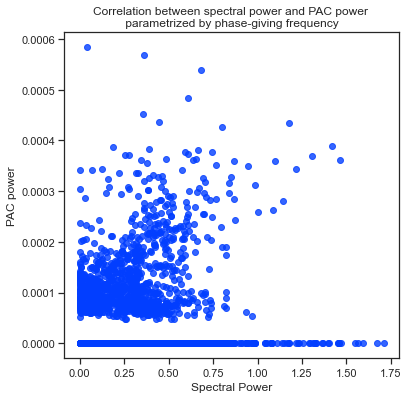

Pearson correlation coefficient:  0.11
Wall time: 15.4 s


In [87]:
%%time

p6 = load_patient(6)
print("Patient 6")
spectral_power, pac_power = get_spectral_pac_correlation(p6, freqs=(6, 30))
plot_correlation_results(spectral_power, pac_power)

### Comparison between different power calculation methods


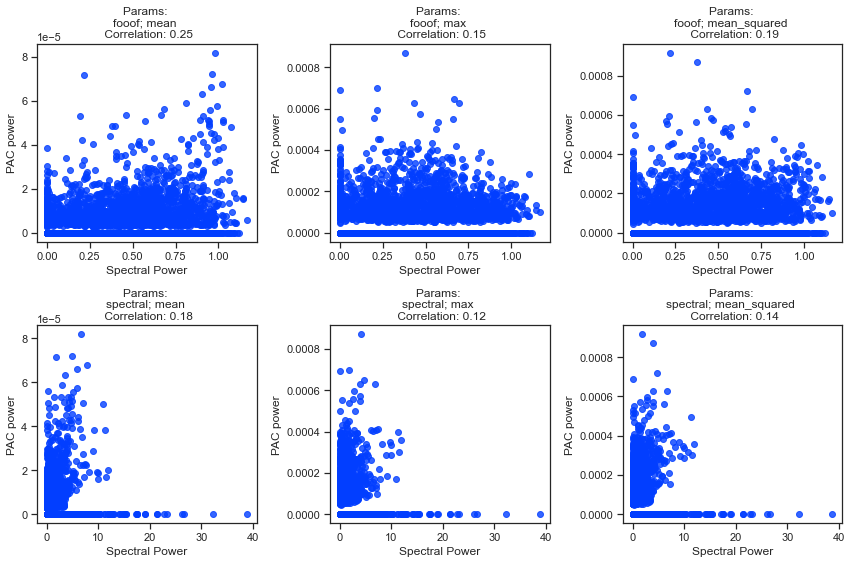

In [12]:
spectral_params = ['fooof', 'spectral']
pac_params = ['mean', 'max', 'mean_squared']

fig, axes = plt.subplots(len(spectral_params), len(pac_params), figsize=(12, 8))

for i, spectral_param in enumerate(spectral_params):
    for j, pac_param in enumerate(pac_params):
        ax = axes[i, j]
        spectral_power, pac_power = get_spectral_pac_correlation(p2, (6, 30), spectral_param, pac_param)
        corr_coef = np.corrcoef(spectral_power, pac_power)[0, 1].round(2)
        
        ax.set_title(f"Params: \n{spectral_param}; {pac_param} \n Correlation: {corr_coef}")
        ax.scatter(spectral_power, pac_power, alpha=0.8)
        ax.set_xlabel("Spectral Power")
        ax.set_ylabel("PAC power")
              
plt.tight_layout()
plt.show()

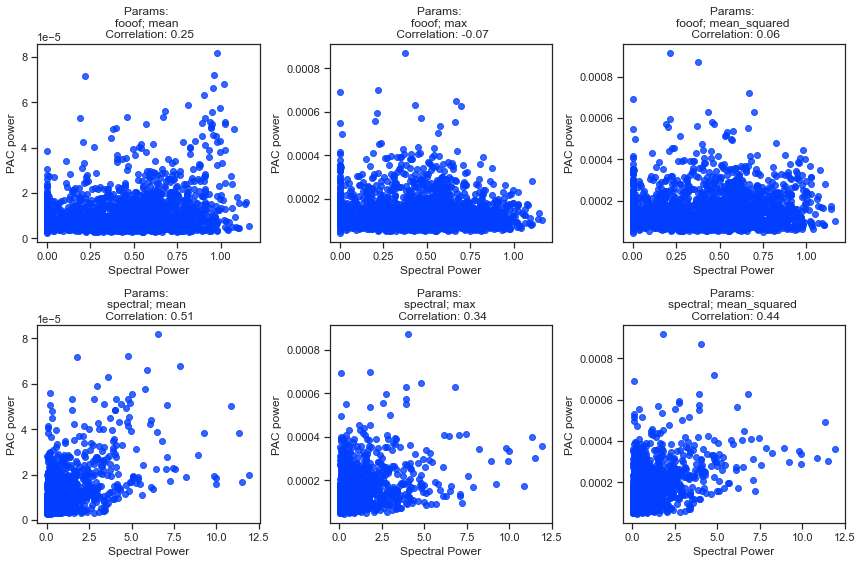

In [11]:
spectral_params = ['fooof', 'spectral']
pac_params = ['mean', 'max', 'mean_squared']

fig, axes = plt.subplots(len(spectral_params), len(pac_params), figsize=(12, 8))

for i, spectral_param in enumerate(spectral_params):
    for j, pac_param in enumerate(pac_params):
        ax = axes[i, j]
        spectral_power, pac_power = get_spectral_pac_correlation(p2, (6, 30), spectral_param, pac_param, ignore_pac_zeros=True)
        corr_coef = np.corrcoef(spectral_power, pac_power)[0, 1].round(2)
        
        ax.set_title(f"Params: \n{spectral_param}; {pac_param} \n Correlation: {corr_coef}")
        ax.scatter(spectral_power, pac_power, alpha=0.8)
        ax.set_xlabel("Spectral Power")
        ax.set_ylabel("PAC power")
              
plt.tight_layout()
plt.show()